## Data prep

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import pickle
from sklearn.metrics import r2_score, classification_report

pd.set_option('mode.chained_assignment',None)

In [2]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return -r2

In [3]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0, parse_dates = [1])
y = df_full.time_to_reservation
df_full.drop(columns=['time_to_reservation', 'hour_index'], inplace=True)

# Load weather
Weather_Scale = pd.read_csv('data/processed/MinMaxWeather.csv', index_col=0)
weather_var = list(Weather_Scale.index)

# Load slicing
with open("data/processed/Sample_CC", "rb") as fp: 
    cc = pickle.load(fp)

df_full.head()

,time,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,2019-10-31 00:00:11,86,0,1.000000,0.000800,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
1,2019-10-31 00:01:04,84,0,0.999989,0.004654,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
2,2019-10-31 00:01:14,99,0,0.999986,0.005381,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
3,2019-10-31 00:02:06,52,0,0.999958,0.009163,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
4,2019-10-31 00:03:33,47,0,0.999880,0.015489,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,1,0


In [4]:
# For classification
Clas_Coef = dict(pd.concat([df_full.time.dt.hour.iloc[cc[0]],y[cc[0]]], axis = 1).groupby('time')['time_to_reservation'].mean()*2)
df_clas = pd.concat([df_full.time.dt.hour.iloc[cc[2]],y[cc[2]]], axis = 1)
df_clas['Cut'] = df_clas.time.map(dict(Clas_Coef))

In [5]:
# Common setting
batch_size = 512
num_epochs = 1501

## No Zones

In [6]:
df = df_full.drop(columns = list(df_full.filter(regex = 'lz').columns) + weather_var + ['dist_to_station','time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,degree,eng_118I,eng_COOPER,eng_I3,eng_X1
0,0.86,0,1.000000,0.000800,0.360118,0,1,0,0
1,0.84,0,0.999989,0.004654,0.197445,0,0,1,0
2,0.99,0,0.999986,0.005381,0.282942,0,0,0,1
3,0.52,0,0.999958,0.009163,0.046701,0,1,0,0
4,0.47,0,0.999880,0.015489,0.353928,0,1,0,0


In [7]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [8]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(9,32),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 865


Epoch  1: Train Loss 0.056729 , Valid Loss -0.084006 ,Train R2 0.093512, Valid R2 0.088802
Epoch 11: Train Loss -0.090877 , Valid Loss -0.092255 ,Train R2 0.102854, Valid R2 0.096655
Epoch 21: Train Loss -0.093743 , Valid Loss -0.094487 ,Train R2 0.105850, Valid R2 0.098856
Epoch 31: Train Loss -0.096136 , Valid Loss -0.096135 ,Train R2 0.107858, Valid R2 0.100428
Epoch 41: Train Loss -0.098900 , Valid Loss -0.098503 ,Train R2 0.110544, Valid R2 0.102757
Epoch 51: Train Loss -0.101418 , Valid Loss -0.100653 ,Train R2 0.112927, Valid R2 0.104942
Epoch 61: Train Loss -0.103220 , Valid Loss -0.102185 ,Train R2 0.114494, Valid R2 0.106429
Epoch 71: Train Loss -0.104767 , Valid Loss -0.103933 ,Train R2 0.116263, Valid R2 0.108223
Epoch 81: Train Loss -0.106142 , Valid Loss -0.105041 ,Train R2 0.117546, Valid R2 0.109358
Epoch 91: Train Loss -0.107240 , Valid Loss -0.105836 ,Train R2 0.118458, Valid R2 0.110141
Epoch 101: Train Loss -0.108101 , Valid Loss -0.106557 ,Train R2 0.119324, Valid 

Net(
  (seq): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

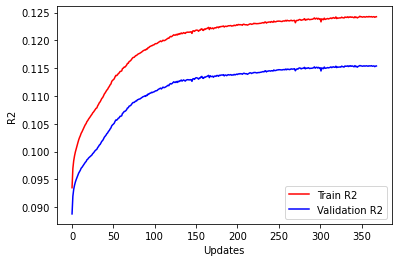

In [9]:
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/NoZones.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

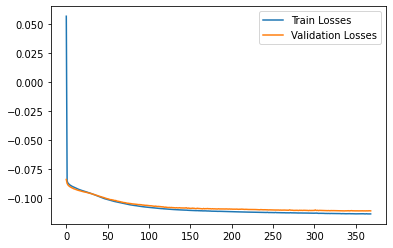

Max Val R2: 0.11547691766138746
Test R2: 0.11933217036772481


In [10]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [11]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.86      0.99      0.92     26743
        Over       0.52      0.04      0.08      4402

    accuracy                           0.86     31145
   macro avg       0.69      0.52      0.50     31145
weighted avg       0.81      0.86      0.80     31145



## Add Zones

In [12]:
df = df_full.drop(columns = weather_var + ['dist_to_station','time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,degree,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.86,0,1.000000,0.000800,0.360118,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.84,0,0.999989,0.004654,0.197445,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.99,0,0.999986,0.005381,0.282942,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.52,0,0.999958,0.009163,0.046701,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.47,0,0.999880,0.015489,0.353928,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [13]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [14]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(265,32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=265, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 9057


Epoch  1: Train Loss 0.500835 , Valid Loss 0.452886 ,Train R2 -0.442214, Valid R2 -0.438612
Epoch 11: Train Loss -0.109852 , Valid Loss -0.127229 ,Train R2 0.136748, Valid R2 0.131804
Epoch 21: Train Loss -0.155494 , Valid Loss -0.170725 ,Train R2 0.181087, Valid R2 0.174783
Epoch 31: Train Loss -0.175542 , Valid Loss -0.188557 ,Train R2 0.200362, Valid R2 0.192700
Epoch 41: Train Loss -0.189013 , Valid Loss -0.198981 ,Train R2 0.212333, Valid R2 0.203184
Epoch 51: Train Loss -0.197494 , Valid Loss -0.205443 ,Train R2 0.220278, Valid R2 0.209668
Epoch 61: Train Loss -0.202398 , Valid Loss -0.209770 ,Train R2 0.225869, Valid R2 0.213978
Epoch 71: Train Loss -0.207289 , Valid Loss -0.212826 ,Train R2 0.230093, Valid R2 0.217025
Epoch 81: Train Loss -0.209622 , Valid Loss -0.214949 ,Train R2 0.233286, Valid R2 0.219100
Epoch 91: Train Loss -0.212981 , Valid Loss -0.216724 ,Train R2 0.236044, Valid R2 0.220883
Epoch 101: Train Loss -0.214059 , Valid Loss -0.217910 ,Train R2 0.238264, Valid

Net(
  (seq): Sequential(
    (0): Linear(in_features=265, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

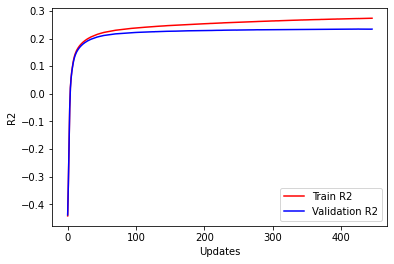

In [15]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/WithZones.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

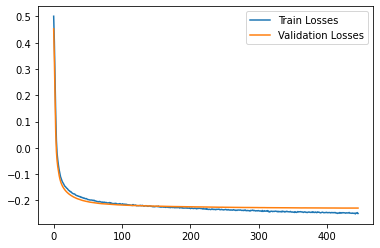

Max Val R2: 0.23445031069610056
Test R2: 0.24077233056628689


In [16]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [17]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.88      0.97      0.92     26743
        Over       0.45      0.17      0.25      4402

    accuracy                           0.85     31145
   macro avg       0.66      0.57      0.58     31145
weighted avg       0.82      0.85      0.82     31145



## Add Encoded zones

In [18]:
df = df_full.drop(columns = weather_var + ['dist_to_station','time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
Mean_Zone_Times = dict(pd.DataFrame({'Zone': df.iloc[np.concatenate(cc[:2])].filter(regex = 'lz').idxmax(axis = 1).values, 'Time':y.iloc[np.concatenate(cc[:2])].values}).groupby('Zone').mean().squeeze())
df['Zone_E'] = df.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
df.drop(columns =  df.filter(regex = 'lz'), inplace = True)
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,degree,eng_118I,eng_COOPER,eng_I3,eng_X1,Zone_E
0,0.86,0,1.000000,0.000800,0.360118,0,1,0,0,3.488767
1,0.84,0,0.999989,0.004654,0.197445,0,0,1,0,3.029264
2,0.99,0,0.999986,0.005381,0.282942,0,0,0,1,2.948682
3,0.52,0,0.999958,0.009163,0.046701,0,1,0,0,1.740973
4,0.47,0,0.999880,0.015489,0.353928,0,1,0,0,7.165938


In [19]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [20]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(10,32),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 897


Epoch  1: Train Loss 0.565850 , Valid Loss 0.473894 ,Train R2 -0.464754, Valid R2 -0.459504
Epoch 11: Train Loss -0.152214 , Valid Loss -0.164996 ,Train R2 0.166823, Valid R2 0.170631
Epoch 21: Train Loss -0.171087 , Valid Loss -0.180203 ,Train R2 0.183024, Valid R2 0.185510
Epoch 31: Train Loss -0.178478 , Valid Loss -0.186557 ,Train R2 0.189936, Valid R2 0.191708
Epoch 41: Train Loss -0.183445 , Valid Loss -0.190933 ,Train R2 0.194620, Valid R2 0.196046
Epoch 51: Train Loss -0.186385 , Valid Loss -0.193501 ,Train R2 0.197409, Valid R2 0.198633
Epoch 61: Train Loss -0.188231 , Valid Loss -0.195122 ,Train R2 0.199168, Valid R2 0.200275
Epoch 71: Train Loss -0.189506 , Valid Loss -0.196268 ,Train R2 0.200379, Valid R2 0.201440
Epoch 81: Train Loss -0.190425 , Valid Loss -0.197055 ,Train R2 0.201241, Valid R2 0.202237
Epoch 91: Train Loss -0.191116 , Valid Loss -0.197606 ,Train R2 0.201882, Valid R2 0.202793
Epoch 101: Train Loss -0.191664 , Valid Loss -0.198053 ,Train R2 0.202397, Valid

Net(
  (seq): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

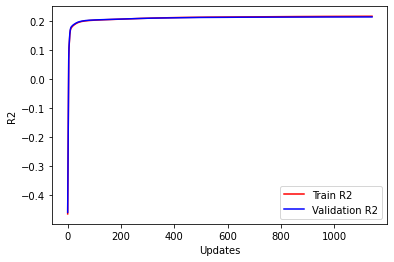

In [21]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0000) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/WithZonesEncoded.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

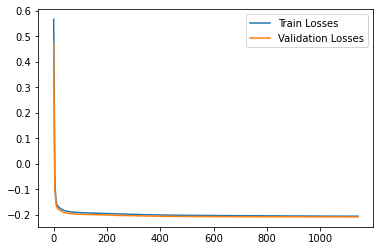

Max Val R2: 0.21358811881640405
Test R2: 0.21101126425013372


In [22]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [23]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.87      0.97      0.92     26743
        Over       0.43      0.11      0.18      4402

    accuracy                           0.85     31145
   macro avg       0.65      0.54      0.55     31145
weighted avg       0.81      0.85      0.81     31145



## Add Weather + Dist to station

In [24]:
df = df_full.drop(columns = list(df_full.filter(regex = 'lz').columns) + ['time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df['dist_to_station'] = df['dist_to_station']/5000
df[Weather_Scale.index] = (df[Weather_Scale.index] - Weather_Scale['Min'])/Weather_Scale['diff']
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,degree,eng_118I,eng_COOPER,eng_I3,eng_X1
0,0.86,0,1.000000,0.000800,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.062560,0.360118,0,1,0,0
1,0.84,0,0.999989,0.004654,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.115475,0.197445,0,0,1,0
2,0.99,0,0.999986,0.005381,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.078189,0.282942,0,0,0,1
3,0.52,0,0.999958,0.009163,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.084367,0.046701,0,1,0,0
4,0.47,0,0.999880,0.015489,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.192328,0.353928,0,1,0,0


In [25]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [26]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(17,128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
) 10625


Epoch  1: Train Loss 0.095448 , Valid Loss -0.072163 ,Train R2 0.080280, Valid R2 0.077413
Epoch 11: Train Loss -0.101285 , Valid Loss -0.110449 ,Train R2 0.123046, Valid R2 0.115207
Epoch 21: Train Loss -0.104345 , Valid Loss -0.112624 ,Train R2 0.126029, Valid R2 0.117395
Epoch 31: Train Loss -0.107706 , Valid Loss -0.113421 ,Train R2 0.127317, Valid R2 0.118166
Epoch 41: Train Loss -0.111520 , Valid Loss -0.114422 ,Train R2 0.128767, Valid R2 0.119183
Epoch 51: Train Loss -0.113146 , Valid Loss -0.114946 ,Train R2 0.129438, Valid R2 0.119685
Epoch 61: Train Loss -0.112925 , Valid Loss -0.115738 ,Train R2 0.130598, Valid R2 0.120520
EarlyStopping counter: 5 out of 20
Epoch 71: Train Loss -0.115193 , Valid Loss -0.116727 ,Train R2 0.131715, Valid R2 0.121498
Epoch 81: Train Loss -0.116289 , Valid Loss -0.117583 ,Train R2 0.132722, Valid R2 0.122340
Epoch 91: Train Loss -0.117089 , Valid Loss -0.118998 ,Train R2 0.134447, Valid R2 0.123845
EarlyStopping counter: 5 out of 20
Epoch 101: 

Net(
  (seq): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

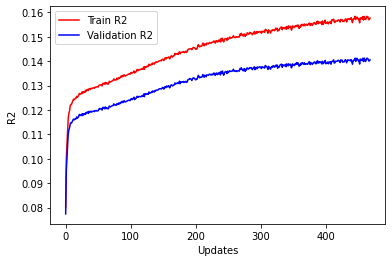

In [27]:
optimizer = optim.Adam(net.parameters(), lr=0.0003, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/WithWeather.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

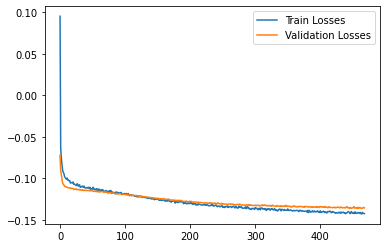

Max Val R2: 0.14130601081826355
Test R2: 0.14854824728911198


In [28]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [29]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.86      0.99      0.92     26743
        Over       0.52      0.05      0.09      4402

    accuracy                           0.86     31145
   macro avg       0.69      0.52      0.51     31145
weighted avg       0.81      0.86      0.81     31145



## With all

In [30]:
df = df_full.drop(columns = ['time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df['dist_to_station'] = df['dist_to_station']/5000
df[Weather_Scale.index] = (df[Weather_Scale.index] - Weather_Scale['Min'])/Weather_Scale['diff']
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.86,0,1.000000,0.000800,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
1,0.84,0,0.999989,0.004654,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
2,0.99,0,0.999986,0.005381,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
3,0.52,0,0.999958,0.009163,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
4,0.47,0,0.999880,0.015489,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,1,0


In [31]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [32]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(273,32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=273, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 9313


Epoch  1: Train Loss 0.553699 , Valid Loss 0.487839 ,Train R2 -0.477429, Valid R2 -0.472775
Epoch 11: Train Loss -0.068828 , Valid Loss -0.102421 ,Train R2 0.109505, Valid R2 0.107477
Epoch 21: Train Loss -0.130721 , Valid Loss -0.155202 ,Train R2 0.164532, Valid R2 0.159292
Epoch 31: Train Loss -0.157398 , Valid Loss -0.176362 ,Train R2 0.187759, Valid R2 0.180510
Epoch 41: Train Loss -0.171037 , Valid Loss -0.189585 ,Train R2 0.202909, Valid R2 0.193777
Epoch 51: Train Loss -0.180645 , Valid Loss -0.199247 ,Train R2 0.214274, Valid R2 0.203390
Epoch 61: Train Loss -0.191506 , Valid Loss -0.205969 ,Train R2 0.222451, Valid R2 0.210101
Epoch 71: Train Loss -0.193752 , Valid Loss -0.210045 ,Train R2 0.227817, Valid R2 0.214112
Epoch 81: Train Loss -0.201389 , Valid Loss -0.212895 ,Train R2 0.231815, Valid R2 0.216905
Epoch 91: Train Loss -0.205001 , Valid Loss -0.215289 ,Train R2 0.235115, Valid R2 0.219287
Epoch 101: Train Loss -0.206329 , Valid Loss -0.216778 ,Train R2 0.237366, Valid

Net(
  (seq): Sequential(
    (0): Linear(in_features=273, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

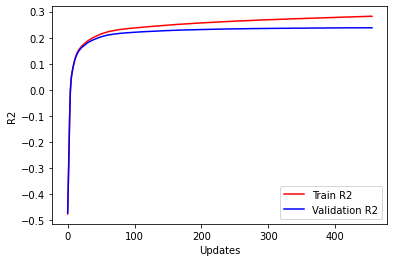

In [33]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/Full.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

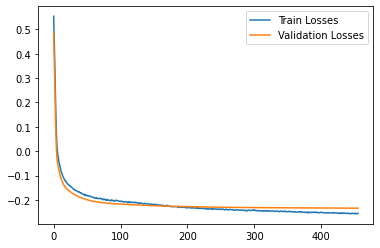

Max Val R2: 0.23822499584821377
Test R2: 0.243429015962501


In [34]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [35]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.88      0.97      0.92     26743
        Over       0.46      0.18      0.26      4402

    accuracy                           0.85     31145
   macro avg       0.67      0.57      0.59     31145
weighted avg       0.82      0.85      0.83     31145



## With all and encoded zones

In [36]:
df = df_full.drop(columns = ['time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df['dist_to_station'] = df['dist_to_station']/5000
df[Weather_Scale.index] = (df[Weather_Scale.index] - Weather_Scale['Min'])/Weather_Scale['diff']
Mean_Zone_Times = dict(pd.DataFrame({'Zone': df.iloc[np.concatenate(cc[:2])].filter(regex = 'lz').idxmax(axis = 1).values, 'Time':y.iloc[np.concatenate(cc[:2])].values}).groupby('Zone').mean().squeeze())
df['Zone_E'] = df.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
df.drop(columns =  df.filter(regex = 'lz'), inplace = True)
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,degree,eng_118I,eng_COOPER,eng_I3,eng_X1,Zone_E
0,0.86,0,1.000000,0.000800,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.062560,0.360118,0,1,0,0,3.488767
1,0.84,0,0.999989,0.004654,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.115475,0.197445,0,0,1,0,3.029264
2,0.99,0,0.999986,0.005381,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.078189,0.282942,0,0,0,1,2.948682
3,0.52,0,0.999958,0.009163,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.084367,0.046701,0,1,0,0,1.740973
4,0.47,0,0.999880,0.015489,0.196347,0.311927,0.0,0.0,0.829885,0.526957,0.85,0.192328,0.353928,0,1,0,0,7.165938


In [37]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [38]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(18,32),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 1153


Epoch  1: Train Loss 0.283952 , Valid Loss 0.188568 ,Train R2 -0.184659, Valid R2 -0.180141
Epoch 11: Train Loss -0.164518 , Valid Loss -0.173651 ,Train R2 0.177715, Valid R2 0.179195
Epoch 21: Train Loss -0.180163 , Valid Loss -0.186491 ,Train R2 0.191698, Valid R2 0.191836
Epoch 31: Train Loss -0.185905 , Valid Loss -0.191395 ,Train R2 0.197127, Valid R2 0.196713
Epoch 41: Train Loss -0.189636 , Valid Loss -0.194656 ,Train R2 0.200682, Valid R2 0.199993
Epoch 51: Train Loss -0.192030 , Valid Loss -0.196770 ,Train R2 0.202957, Valid R2 0.202127
Epoch 61: Train Loss -0.193666 , Valid Loss -0.198239 ,Train R2 0.204535, Valid R2 0.203610
Epoch 71: Train Loss -0.194838 , Valid Loss -0.199242 ,Train R2 0.205665, Valid R2 0.204622
Epoch 81: Train Loss -0.195744 , Valid Loss -0.199969 ,Train R2 0.206527, Valid R2 0.205346
Epoch 91: Train Loss -0.196492 , Valid Loss -0.200548 ,Train R2 0.207238, Valid R2 0.205924
Epoch 101: Train Loss -0.197165 , Valid Loss -0.201034 ,Train R2 0.207872, Valid

Net(
  (seq): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

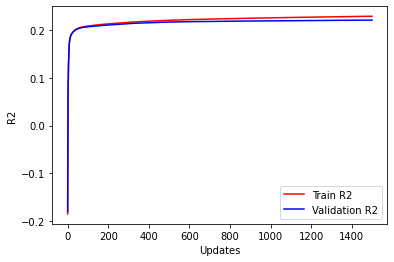

In [39]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/FullEncoded.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

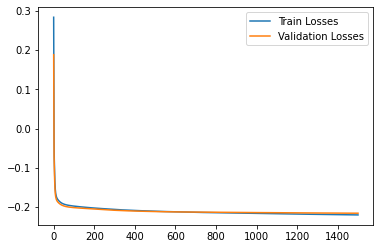

Max Val R2: 0.22024586378471378
Test R2: 0.2177497456717281


In [40]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [41]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.87      0.97      0.92     26743
        Over       0.43      0.13      0.20      4402

    accuracy                           0.85     31145
   macro avg       0.65      0.55      0.56     31145
weighted avg       0.81      0.85      0.82     31145



## Test

In [11]:
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from scipy import sparse
import torch
import torch.nn.functional as F
from datetime import date, timedelta
import torch.optim as optim
import torch.nn as nn
from torch_geometric.nn import Sequential, GCNConv, Linear
from torch_geometric import utils, data
from torch_geometric.loader import DataLoader
from sklearn.metrics import r2_score, classification_report
from torch_scatter import scatter
import subprocess
import time
t = time.time()
pd.set_option('mode.chained_assignment',None)
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
no_days = 4
print(device)
name = "GCN_No_Zones"

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return -r2


batch_size = 512

# Load slicing
with open("data/processed/Sample_NC", "rb") as fp: 
    nc = pickle.load(fp)

with open("data/processed/Sample_CC", "rb") as fp: 
    cc = pickle.load(fp)

# For classification
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0, parse_dates = [1])
Clas_Coef = dict(pd.concat([df_full.time.dt.hour.iloc[cc[0]],df_full.time_to_reservation.iloc[cc[0]]], axis = 1).groupby('time')['time_to_reservation'].mean()*2)
df_clas = pd.concat([df_full.time.dt.hour.iloc[cc[2]],df_full.time_to_reservation.iloc[cc[2]]], axis = 1)
df_clas['Cut'] = df_clas.time.map(dict(Clas_Coef))
df_clas = df_clas.iloc[:sum([len(x[2]) for x in nc[:(no_days+1)]])]
zones = [int(z[3:]) for z in df_full.filter(regex = 'lz').columns]

# Load weather
Weather_Scale = pd.read_csv('data/processed/MinMaxWeather.csv', index_col=0)
weather_var = list(Weather_Scale.index)


def make_PTG(graph, zones, Weather_Scale):
    attr, adj = graph

    # Filter out 
    if (attr.time_to_reservation.values[-1] >= 48) or ~attr.next_customer[-1]:
        return None
    
    if attr.leave_zone[-1] not in zones:
        return None

    # Slice
    _, labels = sparse.csgraph.connected_components(csgraph=adj, directed=False, return_labels=True)
    newl = labels[-1]
    indices = labels == newl   

    attr = attr[indices]
    adj = adj[indices,:].tocsc()[:,indices].tocsr()

    # drop
    attr.drop(columns=['park_location_lat', 'park_location_long', 'leave_location_lat', 'leave_location_long', 'park_fuel', 'park_zone', 'moved', 'movedTF', 'time', 'prev_customer', 'next_customer', 'action'], inplace = True)
    attr.drop(columns = ['leave_zone','dist_to_station'] + list(Weather_Scale.index), inplace = True)
    # One hot encoding
    attr['engine']= pd.Categorical(attr['engine'], categories=['118I', 'I3', 'COOPER', 'X1'])
    attr = pd.get_dummies(attr, columns = ['engine'], prefix='eng')

    # Add degree
    attr['degree'] = np.squeeze(np.asarray(adj.sum(axis=1)))/50

    # Normalize fuel, weahter and dist 
    attr['leave_fuel'] = attr['leave_fuel']/100

    # Get edges
    edge_index, edge_weight = utils.convert.from_scipy_sparse_matrix(adj)

    # Make pytorch data type
    d = data.Data(x = torch.tensor(attr.drop(columns = ['time_to_reservation']).to_numpy(dtype = 'float')).float(), edge_index=edge_index, edge_attr=edge_weight.float(), y = torch.tensor(attr.time_to_reservation.values).float())

    return d


# Load files
sdate = date(2019, 9, 1) # start date
delta = timedelta(days=no_days)
files = ['data/processed/Graphs/'+(sdate + timedelta(days=i)).strftime("%Y%m%d")+'.pickle' for i in range(delta.days + 1)]

dataset = []

with open(files[0], 'rb') as f:
    graph_collection = pickle.load(f)

for g in graph_collection.values():
    res = make_PTG(g,zones, Weather_Scale)
    if res:
        dataset.append(res)

train_data = [dataset[i] for i in nc[0][0]]
val_data = [dataset[i] for i in nc[0][1]]
test_data = [dataset[i] for i in nc[0][2]]


for file, slicer in tqdm(zip(files[1:], nc[1:len(files)]), total = len(files)-1):
    dataset = []
    with open(file, 'rb') as f:
        graph_collection = pickle.load(f)

    for g in graph_collection.values():
        res = make_PTG(g,zones, Weather_Scale)
        if res:
            dataset.append(res)

    train_data = torch.utils.data.ConcatDataset([train_data,[dataset[i] for i in slicer[0]]])
    val_data = torch.utils.data.ConcatDataset([val_data,[dataset[i] for i in slicer[1]]])
    test_data = torch.utils.data.ConcatDataset([test_data,[dataset[i] for i in slicer[2]]])

del dataset, zones


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers = 4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers = 4)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, drop_last=False, num_workers = 4)
del train_data, val_data, test_data
print(f'Time spent: {time.time()-t}')

cpu


100%|██████████| 4/4 [01:14<00:00, 18.71s/it]

Time spent: 102.10001301765442


In [7]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.convM = Sequential('x, edge_index, edge_weight', [
        (GCNConv(9,16, aggr = 'max'),'x, edge_index, edge_weight -> x'),
        nn.ReLU(inplace = True),
        (nn.Dropout(0.25), 'x -> x')
        ])

        self.convA = Sequential('x, edge_index, edge_weight', [
        (GCNConv(9,16, aggr = 'add'),'x, edge_index, edge_weight -> x'),
        nn.ReLU(inplace = True),
        (nn.Dropout(0.2), 'x -> x')
        ])

        self.linS = Sequential('x', [
        (Linear(9,16),'x -> x'),
        nn.ReLU(inplace = True),
        (nn.Dropout(0.2), 'x -> x')
        ])

        self.seq = Sequential('x', [
            (Linear(48,16),'x -> x'),
            nn.ReLU(inplace = True),
            (nn.Dropout(0.2), 'x -> x'),
            (Linear(16,1),'x -> x')
        ])


    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        xConvM = self.convM(x, edge_index, edge_weight)
        xConvA = self.convA(x, edge_index, edge_weight)
        xLin = self.linS(x)

        x = torch.cat([xConvM,xConvA,xLin], axis = 1)

        x = self.seq(x)

        return x.squeeze()

GNN = GCN().to(device)
print(GNN, sum(p.numel() for p in GNN.parameters()))
print('Start learning')

optimizer = optim.Adam(GNN.parameters(), lr=0.001, weight_decay = 0.00001) #Chaged to Adam and learning + regulariztion rate set


# Set number of epochs
num_epochs = 3

# Set up lists for loss/R2
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

#early_stopping = EarlyStopping(patience=20, verbose=False, path = 'Checkpoints/'+name+'.pt')

no_train = len(train_loader)
no_val = len(val_loader)

for epoch in tqdm(range(num_epochs)):
    ### Train
    cur_loss_train = 0
    GNN.train()
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = GNN(batch)
        batch_loss = r2_loss(out[batch.ptr[1:]-1],batch.y[batch.ptr[1:]-1])
        batch_loss.backward()
        optimizer.step()

        cur_loss_train += batch_loss.item()
    
    train_losses.append(cur_loss_train/no_train)

    ### Evaluate training
    with torch.no_grad():
        GNN.eval()
        train_preds, train_targs = [], []
        for batch in train_loader:
            target_mask = batch.ptr[1:]-1
            batch.to(device)
            preds = GNN(batch)
            train_targs += list(batch.y.cpu().numpy()[target_mask])
            train_preds += list(preds.cpu().detach().numpy()[target_mask])


    ### Evaluate validation
        val_preds, val_targs = [], []
        cur_loss_val = 0
        for batch in val_loader:
            batch.to(device)
            preds = GNN(batch)[batch.ptr[1:]-1]
            y_val = batch.y[batch.ptr[1:]-1]
            val_targs += list(y_val.cpu().numpy())
            val_preds += list(preds.cpu().detach().numpy())
            cur_loss_val += r2_loss(preds, y_val)

        val_losses.append(cur_loss_val/no_val)


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    #early_stopping(val_losses[-1], GNN)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break

    print("Epoch %2i: Train Loss %f, Valid Loss %f, Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))



GCN(
  (convM): Sequential(
    (0): GCNConv(9, 16)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
  )
  (convA): Sequential(
    (0): GCNConv(9, 16)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (linS): Sequential(
    (0): Linear(9, 16, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (seq): Sequential(
    (0): Linear(48, 16, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(16, 1, bias=True)
  )
) 1281
Start learning


 33%|███▎      | 1/3 [01:36<03:12, 96.19s/it]

Epoch  1: Train Loss 0.487284, Valid Loss 0.421294, Train R2 -0.447566, Valid R2 -0.415786


 67%|██████▋   | 2/3 [03:04<01:31, 91.40s/it]

Epoch  2: Train Loss 0.413234, Valid Loss 0.342997, Train R2 -0.368686, Valid R2 -0.340808


100%|██████████| 3/3 [04:29<00:00, 89.80s/it]

Epoch  3: Train Loss 0.325760, Valid Loss 0.241679, Train R2 -0.259957, Valid R2 -0.240202


In [38]:
tmp = df_full.iloc[sorted(cc[2])]
tmp[(tmp.time.dt.day <=5) & (tmp.time.dt.month == 9)].time_to_reservation.sort_values()

38577      0.003333
14989      0.003611
15901      0.003889
112992     0.004444
15819      0.004722
            ...    
113893    31.811111
37840     34.432499
39791     35.235279
81276     37.403057
37659     37.793888
Name: time_to_reservation, Length: 2600, dtype: float64

In [44]:
df_clas.time_to_reservation.sort_values()

8342      0.002222
8493      0.003889
8424      0.003889
9317      0.004167
2107      0.004444
           ...    
5923     32.454723
9801     33.096111
11969    34.795834
12147    40.156113
9731     45.014721
Name: time_to_reservation, Length: 2621, dtype: float64

In [42]:
#sorted([obs.y[-1].numpy().item() for obs in test_loader.dataset])
#df_clas.iloc[:sum([len(x[2]) for x in nc[:(no_days+1)]])]
sum([len(x[2]) for x in nc[:(no_days+1)]])

2621

In [46]:
df_full.time.dt.hour.iloc[cc[2]]

2216      19
1624      16
2234      19
45         1
245        7
          ..
153451    23
154576    14
155005    17
154231    11
155409    20
Name: time, Length: 31145, dtype: int64

In [13]:
df_clas = pd.concat([df_full.time.dt.hour.iloc[cc[2]],df_full.time_to_reservation.iloc[cc[2]]], axis = 1)
df_clas['Cut'] = df_clas.time.map(dict(Clas_Coef))
df_clas = df_clas.iloc[:sum([len(x[2]) for x in nc[:(no_days+1)]])]

2621

In [49]:
df_clas['Preds'] = [GNN(b).detach().numpy().item(-1) for b in test_loader]
test_targest = [obs.y[-1].numpy().item() for obs in test_loader.dataset]

In [50]:
df_clas['TT'] = test_targest

In [51]:
df_clas

,time,time_to_reservation,Cut,Preds,TT
2216,19,13.948055,7.243366,0.957741,1.858333
1624,16,0.555278,4.615390,0.928413,0.848333
2234,19,0.736667,7.243366,1.079555,3.030000
45,1,7.195000,12.881520,1.101890,8.988334
245,7,0.416389,6.139857,0.873445,1.581111
...,...,...,...,...,...
11324,16,16.043056,4.615390,0.652851,0.998333
13099,13,0.967778,4.174176,1.009401,6.629167
11349,17,1.674444,5.284467,0.714107,0.120000
11431,17,0.240000,5.284467,0.631236,3.199445


In [52]:
print(f'Test score: {r2_score(df_clas.time_to_reservation,df_clas.Preds)}')
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over'], zero_division = 0))

Test score: -0.3590671519533233
              precision    recall  f1-score   support

       Under       0.84      1.00      0.91      2191
        Over       0.00      0.00      0.00       430

    accuracy                           0.84      2621
   macro avg       0.42      0.50      0.46      2621
weighted avg       0.70      0.84      0.76      2621



In [53]:
print(f'Test score: {r2_score(df_clas.TT,df_clas.Preds)}')
print(classification_report(df_clas.TT > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over'], zero_division = 0))

Test score: -0.2651467790463069
              precision    recall  f1-score   support

       Under       0.83      1.00      0.91      2181
        Over       0.00      0.00      0.00       440

    accuracy                           0.83      2621
   macro avg       0.42      0.50      0.45      2621
weighted avg       0.69      0.83      0.76      2621

